In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

from notebooks.util.distribution_utils import *
from liquidity.features import compute_returns

from hurst_exponent.util.utils import augmented_dickey_fuller

In [35]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# Number of events to use
EVENTS_RANGE = 500000

## Load market orders raw sample data

In [37]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [38]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,135.963741,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,135.963741,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,135.963741,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,3572,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,...,151.020334,0.025,0.025,0.04,2017-12-29,0.019713,322243,3577,2.112474,321
1411992,3573,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,...,151.020334,-0.030,0.030,0.07,2017-12-29,0.019713,322243,3577,1.324325,-200
1411993,3574,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,1.324325,-200
1411994,3575,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,0.013243,-2


## 1. Returns

In [39]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'AAPL': appl_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns = {stock: data.head(1000000) for stock, data in returns.items()}

### 1.1. Stationarity Test
To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:
- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.
- **H1:** The time series is stationary.
- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [40]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -282.90
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -508.66
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.00
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.36
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 1.2. Plot returns density functions

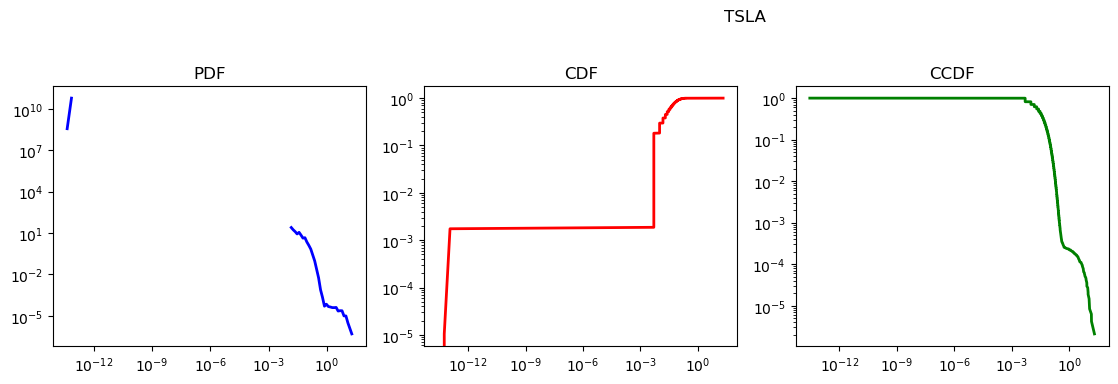

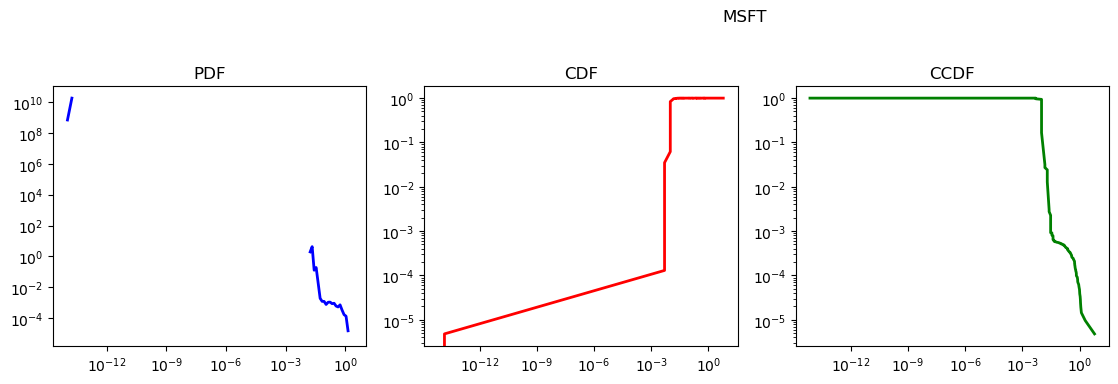

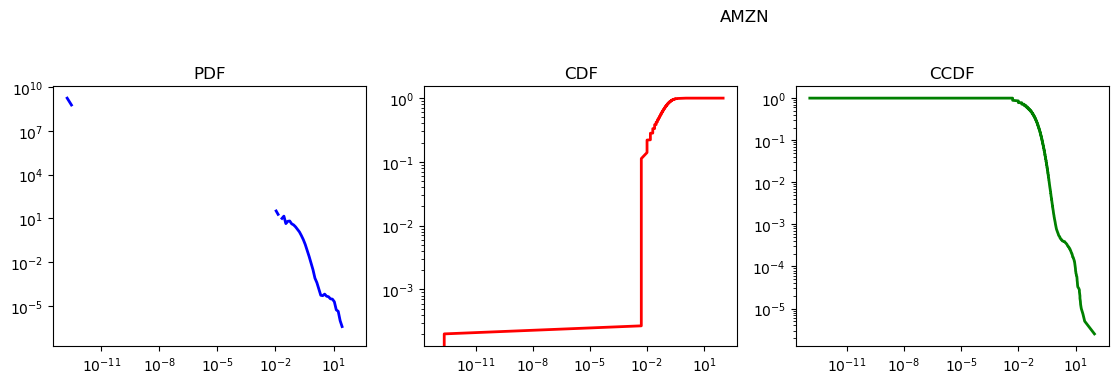

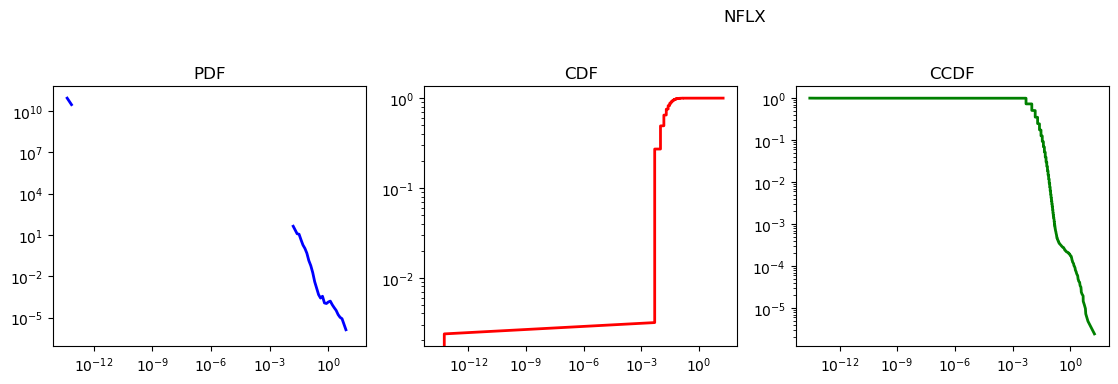

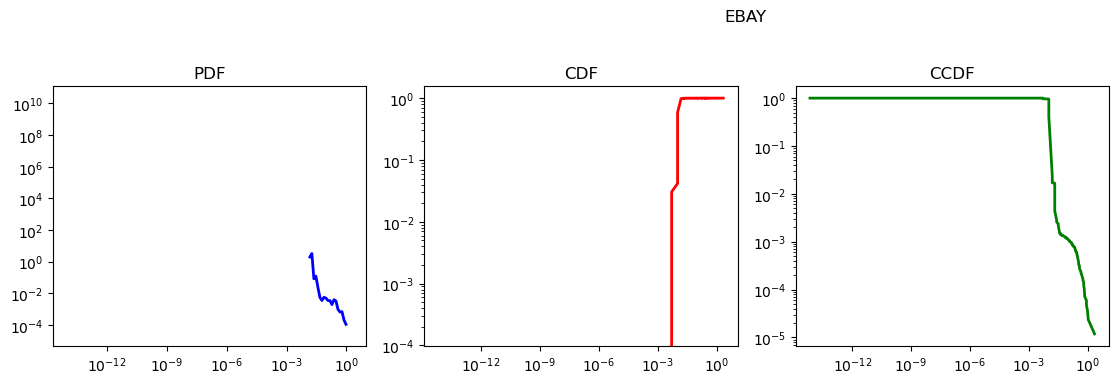

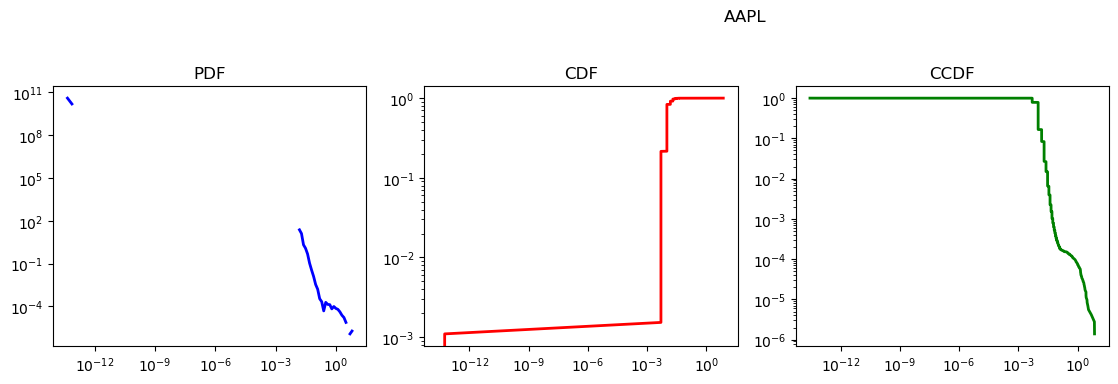

In [41]:
# Plot for each stock
for stock_name, data in returns.items():
    plot_distributions(stock_name, data)

### 1.3. Fit returns power law distribution

In [42]:
# 1. Fit Powerlaw and retrieve fitted object/ results
returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_returns_distributions.pkl')

if not os.path.exists(returns_distributions_data):
    returns_fit_objects = fit_powerlaw(data_dict=returns, filename=returns_distributions_data)
else:
    returns_fit_objects = load_fit_objects(returns_distributions_data)

returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2f3e2a550>,
 'MSFT': <powerlaw.Fit at 0x2e0be0250>,
 'AMZN': <powerlaw.Fit at 0x2e0be0650>,
 'NFLX': <powerlaw.Fit at 0x2b7019250>,
 'EBAY': <powerlaw.Fit at 0x2f11eff90>,
 'AAPL': <powerlaw.Fit at 0x2b701de10>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

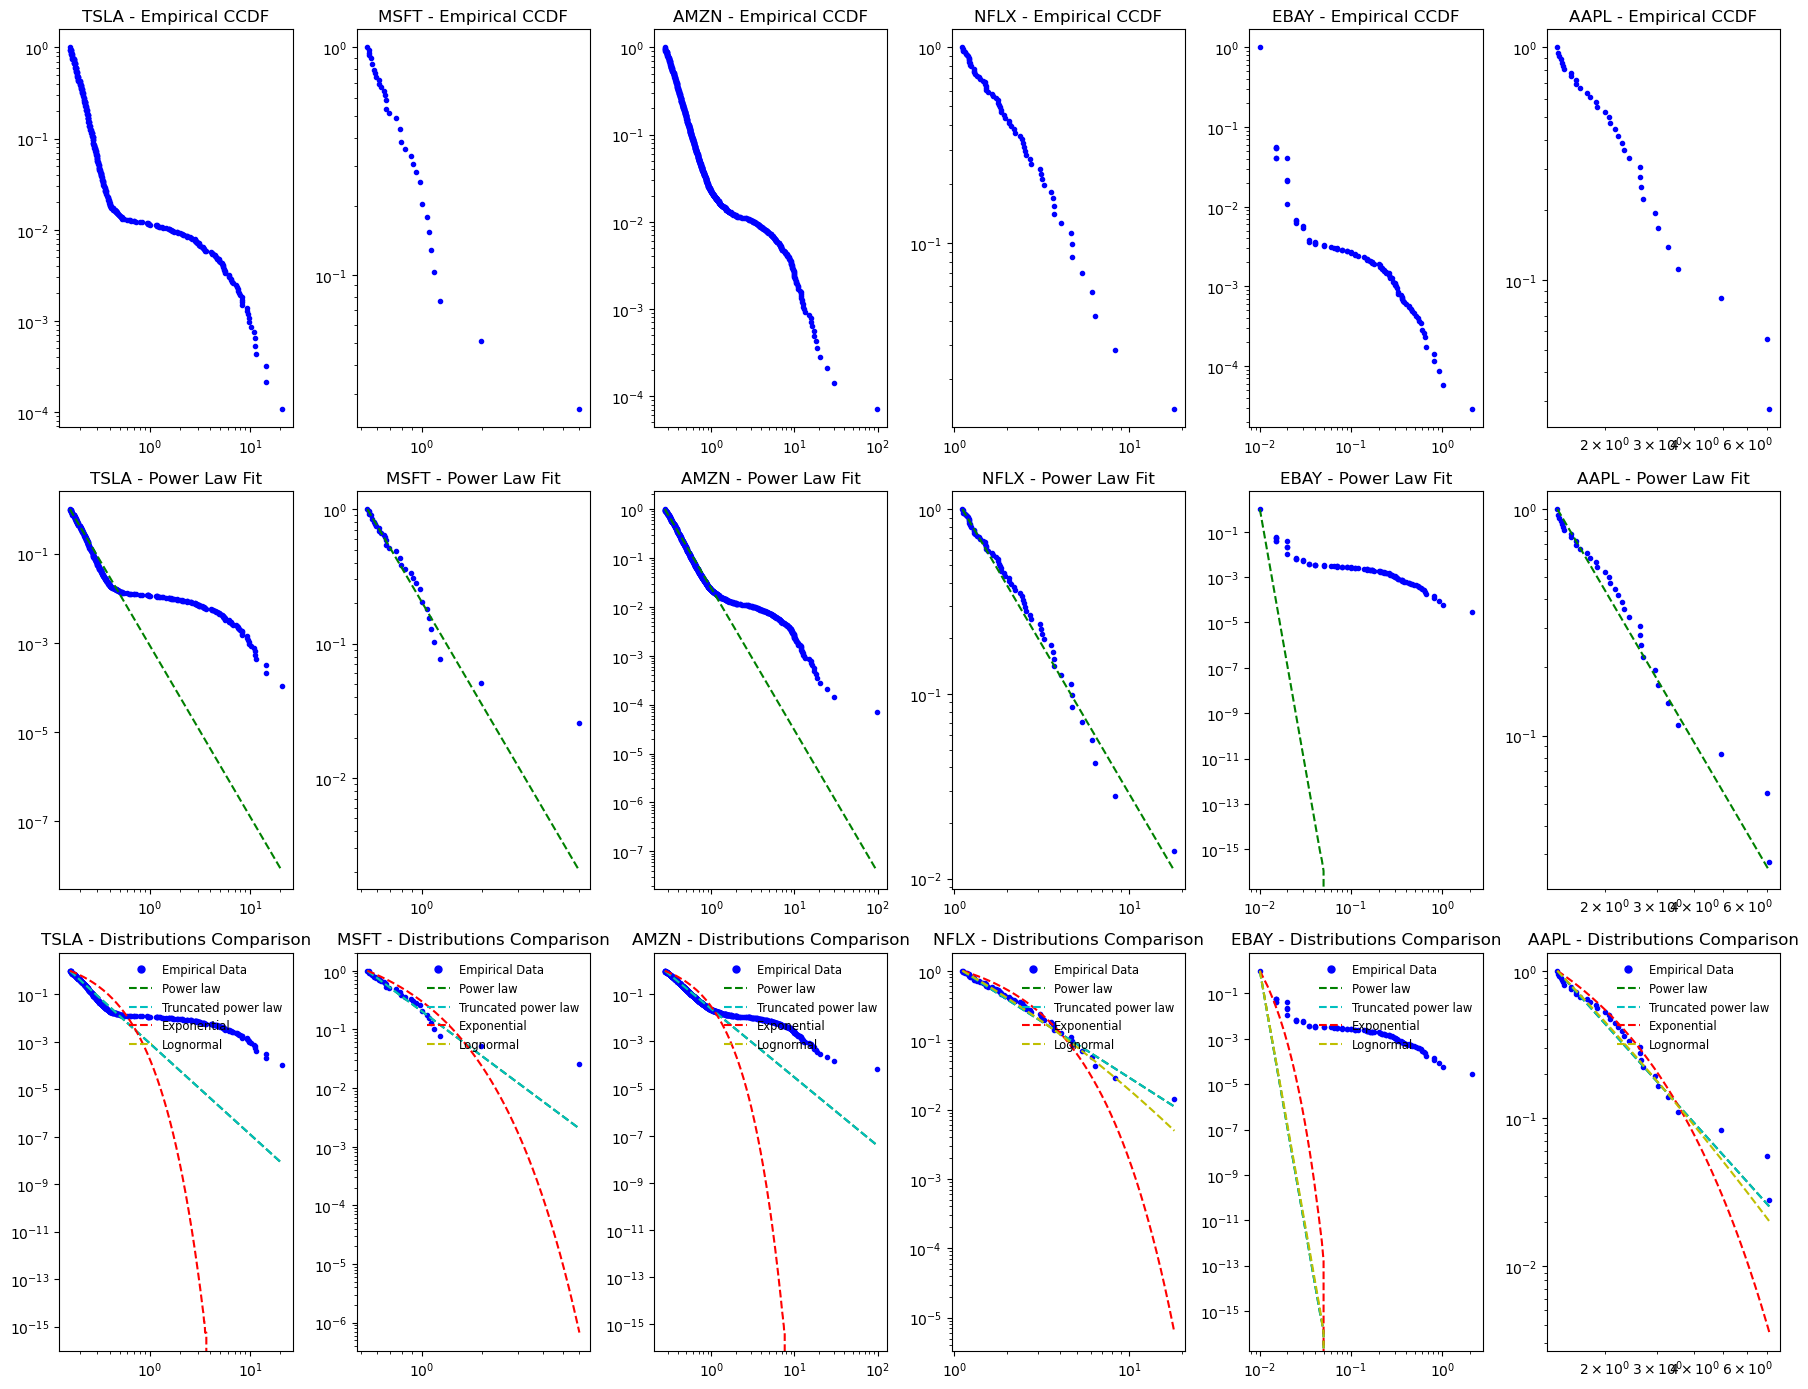

In [43]:
# Plot fitted objects
plot_fit_objects(returns_fit_objects)

#### 1.3.1. Retrieve returns power law fitting results

In [44]:
# Get fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'power_law')
print(returns_power_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.840474  0.160     0.054787
1  MSFT    power_law   3.569960  0.540     0.057297
2  AMZN    power_law   3.898604  0.275     0.027838
3  NFLX    power_law   2.615621  1.110     0.066814
4  EBAY    power_law  23.883643  0.010     0.056598
5  AAPL    power_law   3.250864  1.390     0.091962


In [45]:
# Average Alpha exponents across stocks
min_alpha = returns_power_results['alpha'].min()
max_alpha = returns_power_results['alpha'].max()
avg_alpha = returns_power_results['alpha'].mean()
std_dev_alpha = returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.615621092658862
Max Alpha: 23.8836425132098
Average Alpha: 7.009860831015982
std_dev_alpha: 8.299192580460232


In [46]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'truncated_power_law')
print(returns_power_results)

  Stock         Distribution      alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law   4.840582  8.091152e-09  0.160     0.054790
1  MSFT  truncated_power_law   3.569937  6.620022e-09  0.540     0.057293
2  AMZN  truncated_power_law   3.905605  8.067746e-09  0.275     0.027718
3  NFLX  truncated_power_law   2.264098  7.991768e-02  1.110     0.050154
4  EBAY  truncated_power_law  23.883701  2.964813e-08  0.010     0.056598
5  AAPL  truncated_power_law   2.776156  1.293403e-01  1.390     0.096668


In [47]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'exponential')
print(returns_power_results)

  Stock Distribution      Lambda   xmin  KS Distance
0  TSLA  exponential   10.196214  0.160     0.291478
1  MSFT  exponential    2.592228  0.540     0.175455
2  AMZN  exponential    4.864349  0.275     0.228868
3  NFLX  exponential    0.707680  1.110     0.142518
4  EBAY  exponential  728.148076  0.010     0.039806
5  AAPL  exponential    0.984286  1.390     0.127864


#### 1.3.2. Compare Alternative Distributions

In [48]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
returns_powerlaw_exponential = distribution_compare(returns_fit_objects, 'exponential')
display(returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,10.196214,0.160,4.840474,0.054787,0.291478,11.796439,4.071791e-32
1,MSFT,exponential,2.592228,0.540,3.569960,0.057297,0.175455,1.312028,1.895107e-01
2,AMZN,exponential,4.864349,0.275,3.898604,0.027838,0.228868,10.233240,1.407311e-24
3,NFLX,exponential,0.707680,1.110,2.615621,0.066814,0.142518,1.113604,2.654491e-01
4,EBAY,exponential,728.148076,0.010,23.883643,0.056598,0.039806,16.567693,1.193162e-61
5,AAPL,exponential,0.984286,1.390,3.250864,0.091962,0.127864,0.880109,3.788003e-01


## 2. Percentage returns

In [49]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'AAPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### 2.1. Stationarity Test

In [50]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -283.22
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -509.01
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.07
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.44
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 2.2. Percentage return density functions

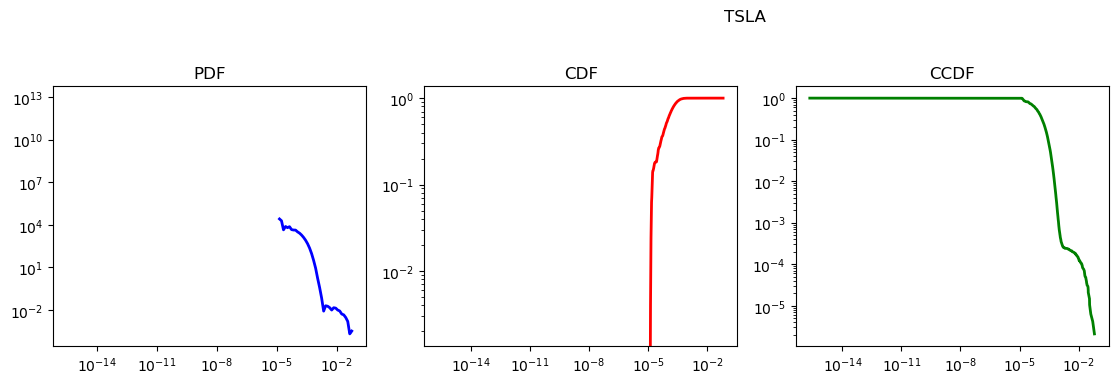

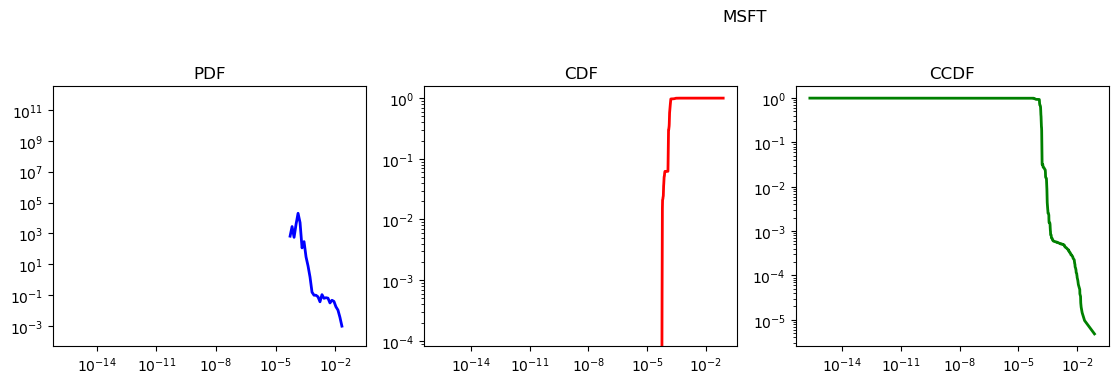

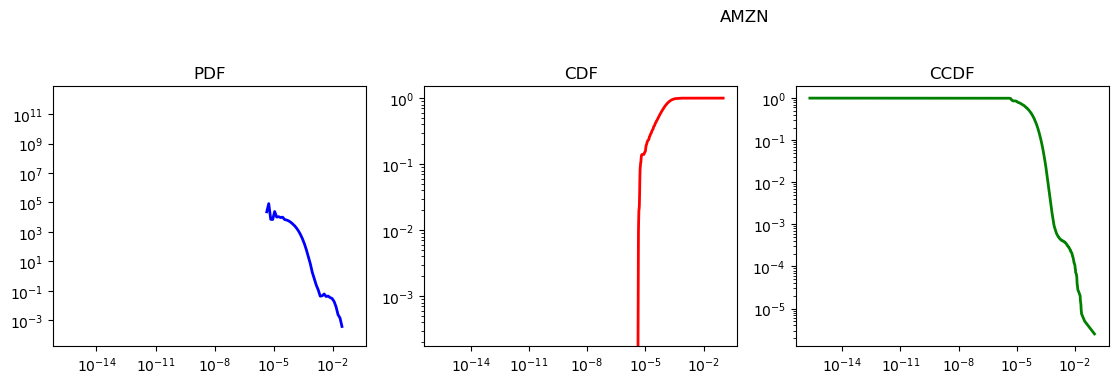

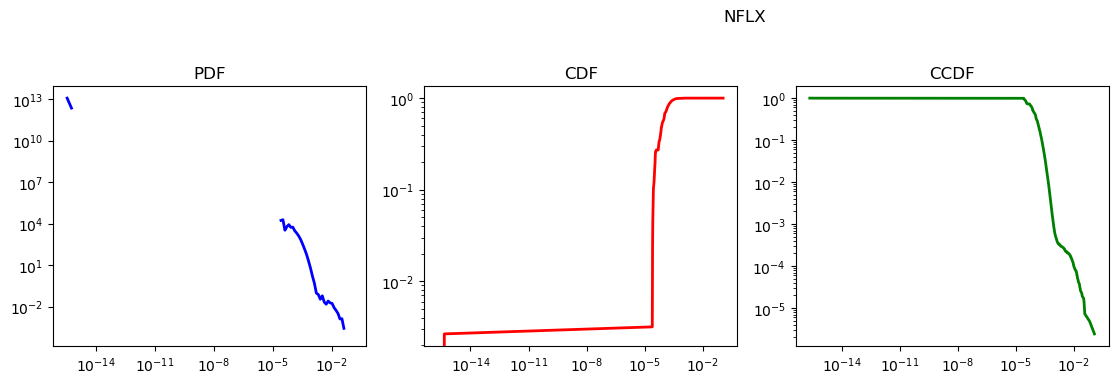

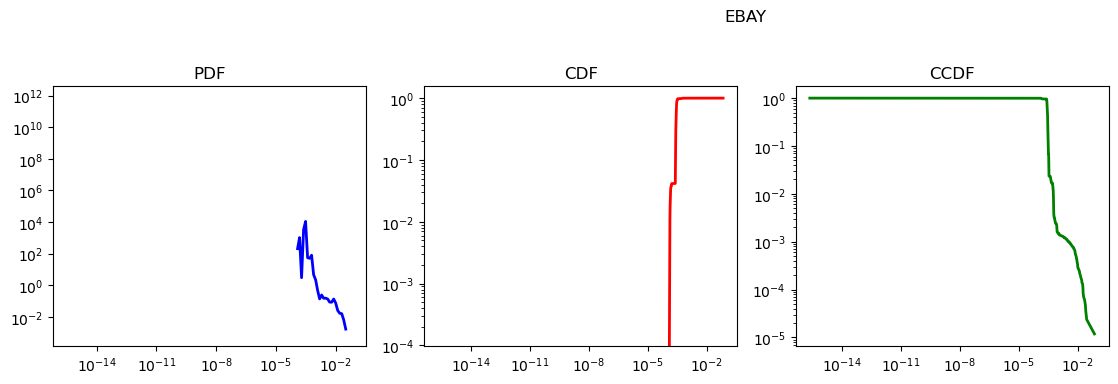

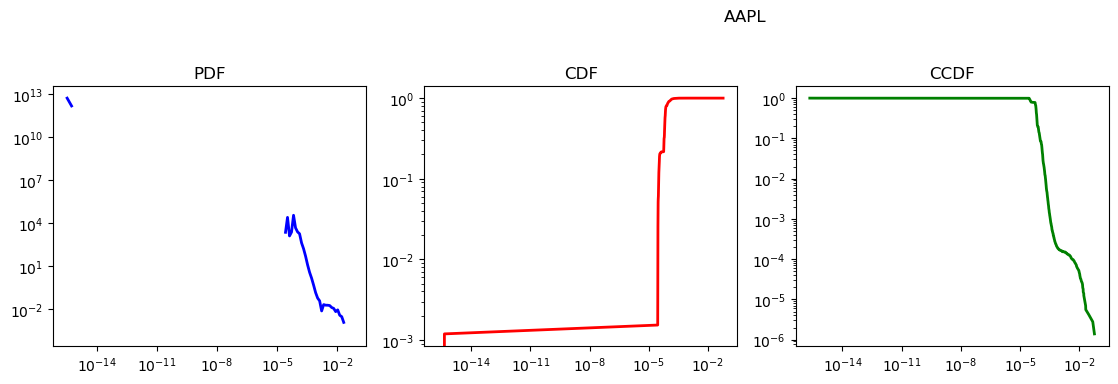

In [51]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in percentage_returns.items():
    plot_distributions(stock_name, data)

### 2.3. Fit power law distribution to percentage returns

In [52]:
# 1. Fit Powerlaw and retrieve fitted object/ results
percentage_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_percentage_returns_distributions.pkl')

if not os.path.exists(percentage_returns_distributions_data):
    percentage_returns_fit_objects = fit_powerlaw(data_dict=percentage_returns, filename=percentage_returns_distributions_data)
else:
    percentage_returns_fit_objects = load_fit_objects(percentage_returns_distributions_data)

percentage_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2a2530a50>,
 'MSFT': <powerlaw.Fit at 0x175fe7050>,
 'AMZN': <powerlaw.Fit at 0x176f6a490>,
 'NFLX': <powerlaw.Fit at 0x176f98190>,
 'EBAY': <powerlaw.Fit at 0x177675f50>,
 'AAPL': <powerlaw.Fit at 0x17624ff90>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

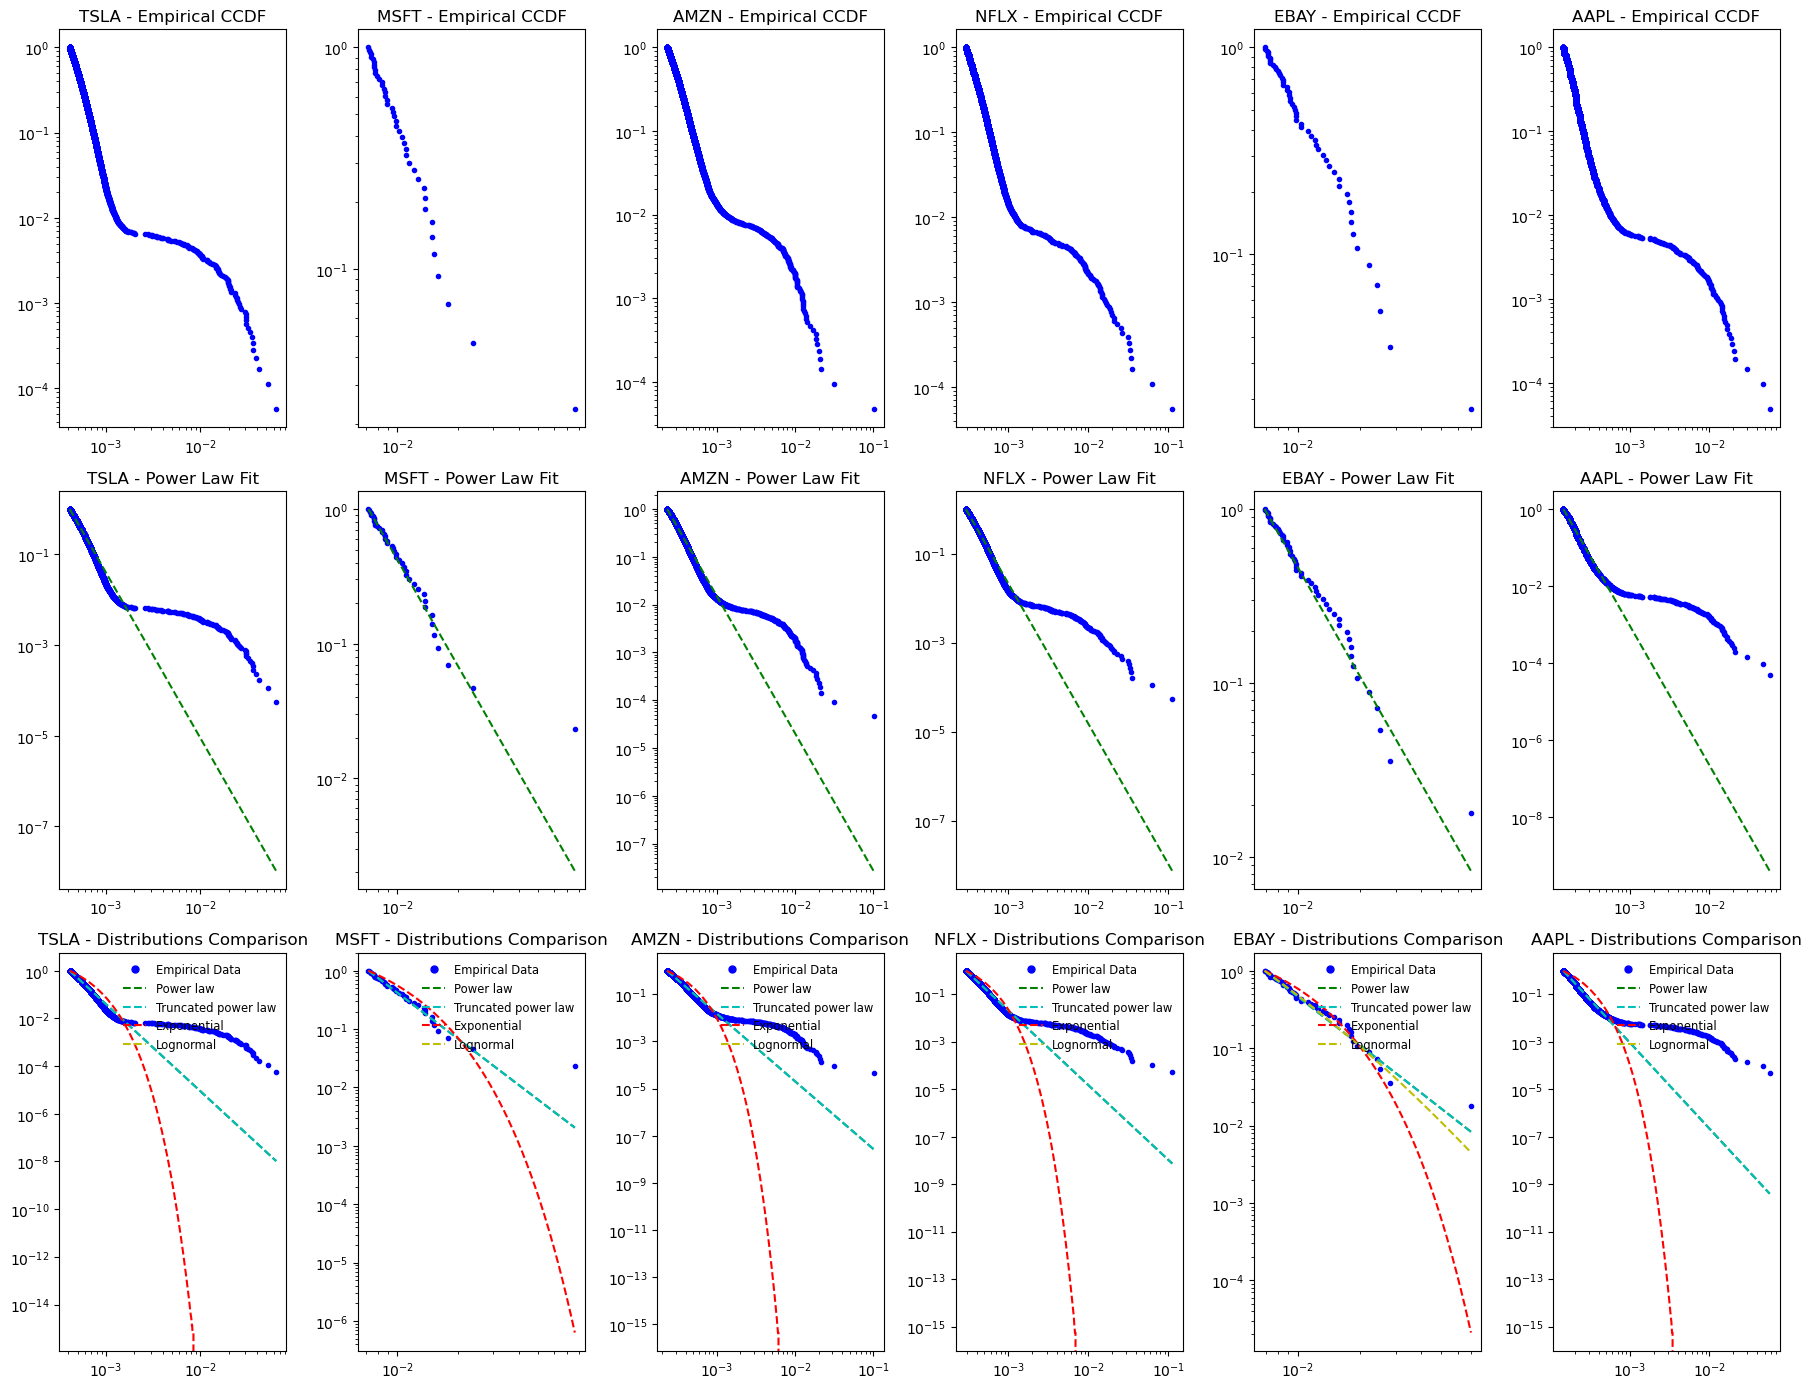

In [53]:
# Plot fitted objects
plot_fit_objects(percentage_returns_fit_objects)

#### 2.3.1. Retrieve Power law fitting results

In [54]:
# Get fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'power_law')
print(percentage_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.645614  0.000413     0.025114
1  MSFT    power_law  3.621321  0.007184     0.043615
2  AMZN    power_law  3.874606  0.000233     0.024971
3  NFLX    power_law  4.146440  0.000294     0.021133
4  EBAY    power_law  3.070179  0.006900     0.054187
5  AAPL    power_law  4.606503  0.000144     0.044306


In [55]:
# Average Alpha exponents across stocks
min_alpha = percentage_returns_results['alpha'].min()
max_alpha = percentage_returns_results['alpha'].max()
avg_alpha = percentage_returns_results['alpha'].mean()
std_dev_alpha = percentage_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.070178622183131
Max Alpha: 4.645613648183479
Average Alpha: 3.9941105175517926
std_dev_alpha: 0.6049112943511536


In [56]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'truncated_power_law')
print(percentage_returns_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  4.645440   0.000007  0.000413     0.025124
1  MSFT  truncated_power_law  3.621223   0.000002  0.007184     0.043602
2  AMZN  truncated_power_law  3.885448   0.000024  0.000233     0.023954
3  NFLX  truncated_power_law  4.146470   0.000024  0.000294     0.021136
4  EBAY  truncated_power_law  2.743468  15.900455  0.006900     0.050097
5  AAPL  truncated_power_law  4.610980   0.000005  0.000144     0.044685


In [57]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
percentage_returns_results = get_fitting_params(percentage_returns_fit_objects, 'exponential')
print(percentage_returns_results)

  Stock Distribution        Lambda      xmin  KS Distance
0  TSLA  exponential   4417.271758  0.000413     0.193345
1  MSFT  exponential    207.039746  0.007184     0.146388
2  AMZN  exponential   6050.244799  0.000233     0.187236
3  NFLX  exponential   5352.479648  0.000294     0.186628
4  EBAY  exponential    171.218736  0.006900     0.158395
5  AAPL  exponential  10736.711869  0.000144     0.278834


#### 2.3.2. Compare Alternative Distributions

In [58]:
# Compare against alternative heavy-tailed distributions
percentage_returns_powerlaw_exponential = distribution_compare(percentage_returns_fit_objects, 'exponential')
display(percentage_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,4417.271758,0.000413,4.645614,0.025114,0.193345,10.322394,5.581401e-25
1,MSFT,exponential,207.039746,0.007184,3.621321,0.043615,0.146388,1.209049,2.266439e-01
2,AMZN,exponential,6050.244799,0.000233,3.874606,0.024971,0.187236,9.959838,2.284336e-23
3,NFLX,exponential,5352.479648,0.000294,4.146440,0.021133,0.186628,7.960030,1.719970e-15
4,EBAY,exponential,171.218736,0.006900,3.070179,0.054187,0.158395,0.892975,3.718707e-01
5,AAPL,exponential,10736.711869,0.000144,4.606503,0.044306,0.278834,10.231431,1.433841e-24


## 3. Log Returns

In [59]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df, )['log_returns']
msft_log_returns = compute_returns(msft_raw_df, )['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df,)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df, )['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df,)['log_returns']
appl_log_returns = compute_returns(appl_raw_df,)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'AAPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### 3.1. Stationarity Test

In [60]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -283.20
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -509.02
p-value: 0.00,
N: 499997, 
critical values: {'1%': -3.4303630787456174, '5%': -2.8615457806516207, '10%': -2.5667730768296972}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -70.13
p-value: 0.00,
N: 499897, 
critical values: {'1%': -3.430363081361919, '5%': -2.8615457818079926, '10%': -2.566773077445192}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -309.32
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.2. Log return density functions

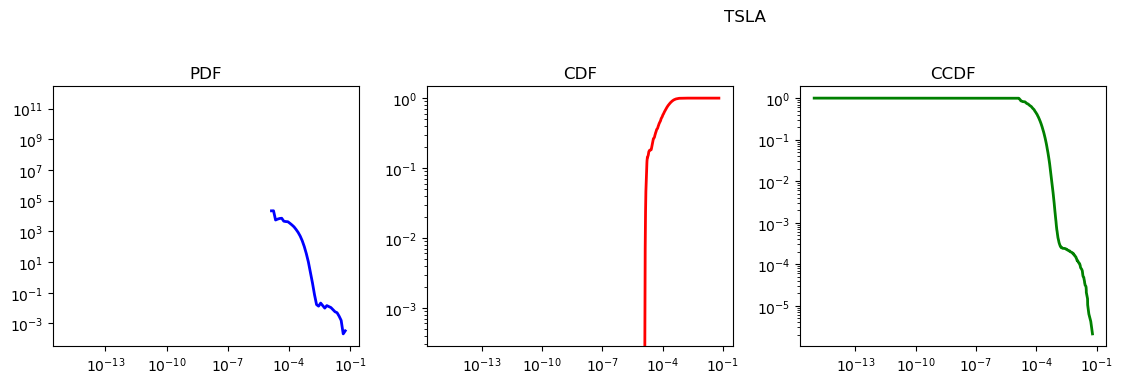

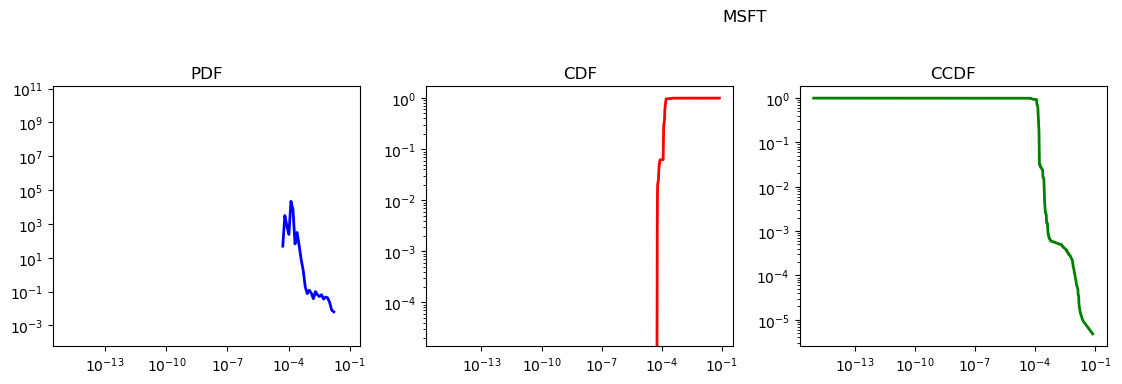

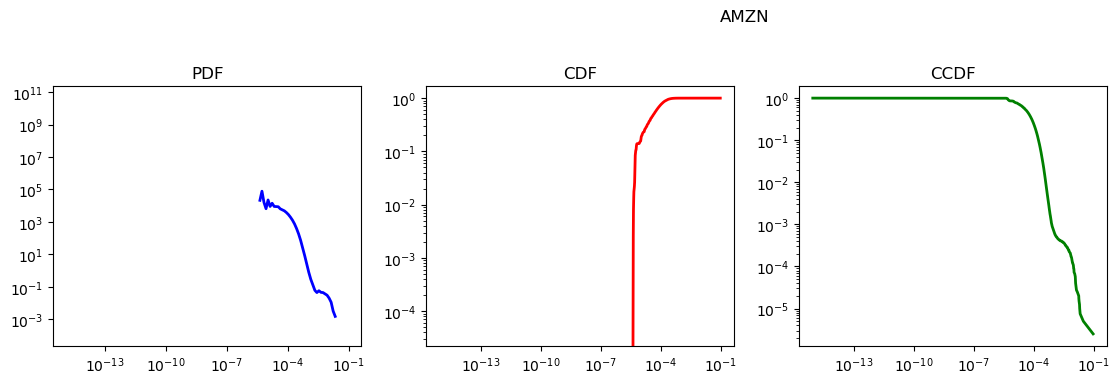

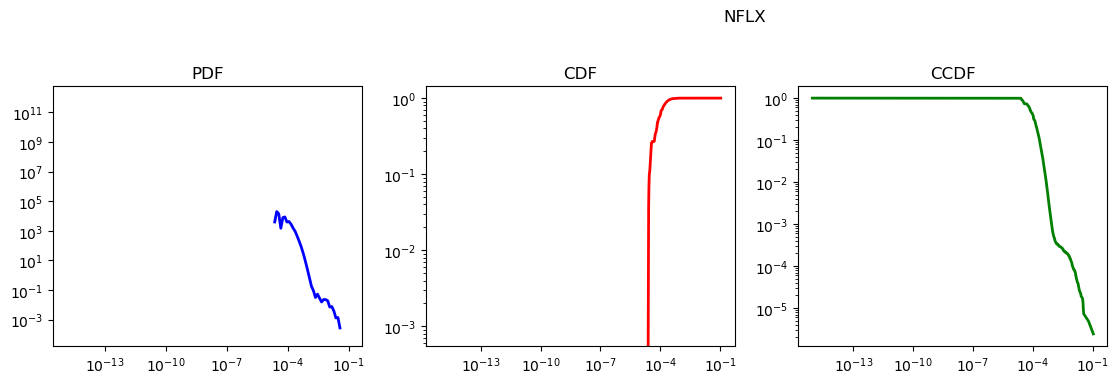

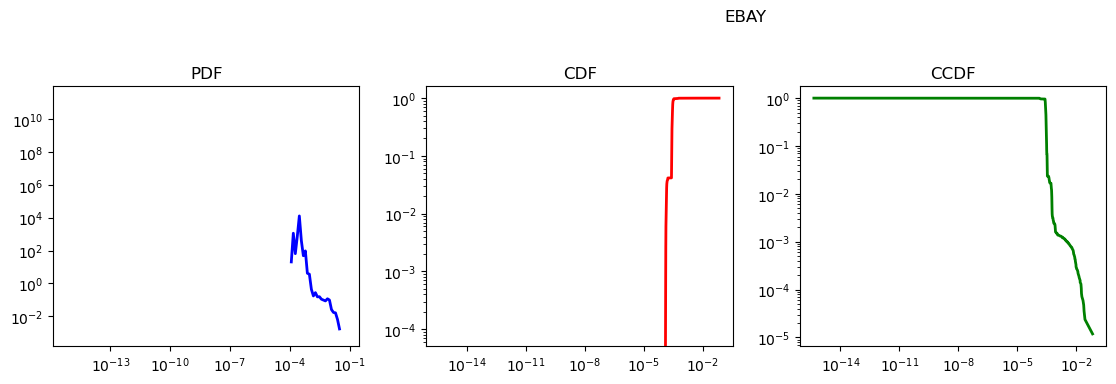

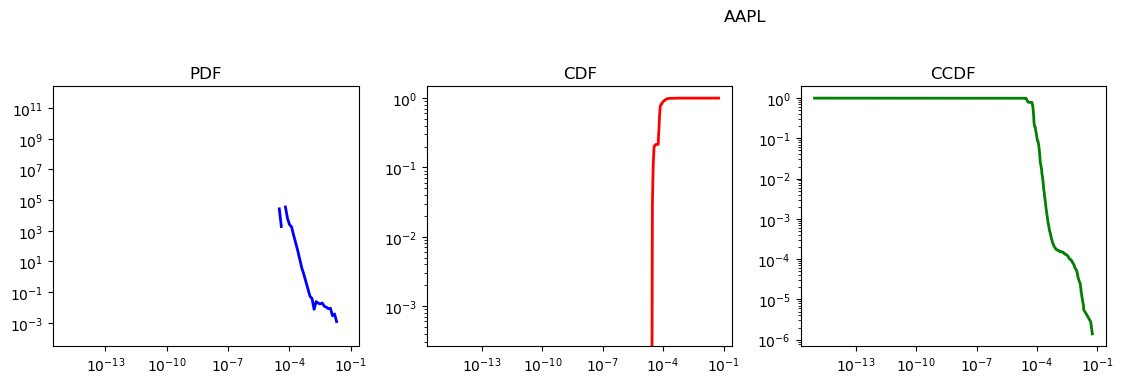

In [61]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in log_returns.items():
    plot_distributions(stock_name, data)

### 3.3. Fit power law distribution to log returns

In [62]:
# 1. Fit Powerlaw and retrieve fitted object/ results
log_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_log_returns_distributions.pkl')

if not os.path.exists(log_returns_distributions_data):
    log_returns_fit_objects = fit_powerlaw(data_dict=log_returns, filename=log_returns_distributions_data)
else:
    log_returns_fit_objects = load_fit_objects(log_returns_distributions_data)

log_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x2e0f78850>,
 'MSFT': <powerlaw.Fit at 0x2aca88b90>,
 'AMZN': <powerlaw.Fit at 0x2f2797cd0>,
 'NFLX': <powerlaw.Fit at 0x2f2797350>,
 'EBAY': <powerlaw.Fit at 0x2f2797250>,
 'AAPL': <powerlaw.Fit at 0x2f2797390>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

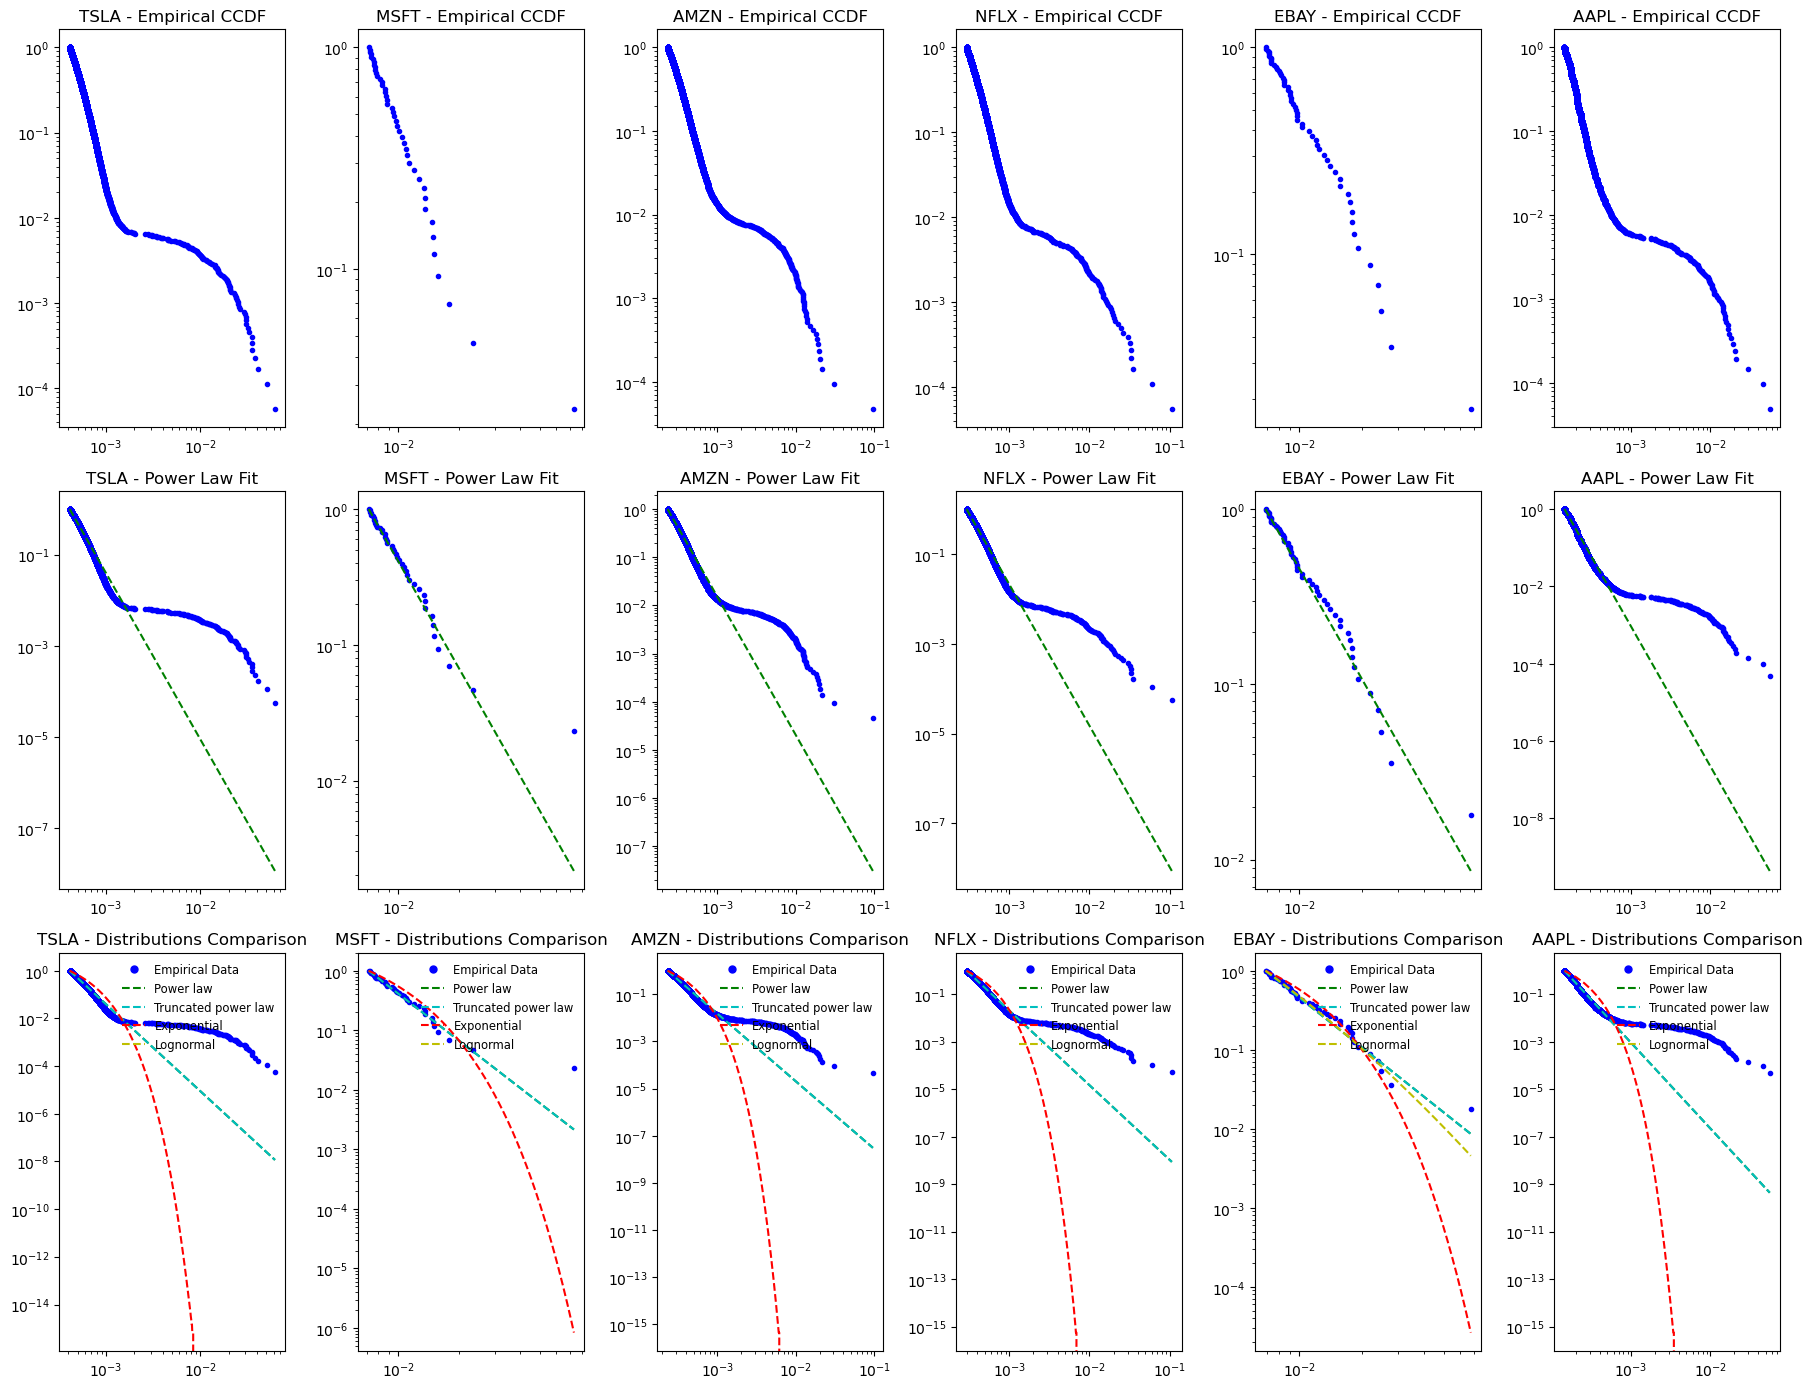

In [63]:
# Plot fitted objects
plot_fit_objects(log_returns_fit_objects)

#### 3.3.1. Retrieve Power law fitting results

In [64]:
# Get fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'power_law')
print(log_returns_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.647112  0.000413     0.025091
1  MSFT    power_law  3.637738  0.007158     0.044361
2  AMZN    power_law  3.875287  0.000233     0.024953
3  NFLX    power_law  4.147362  0.000294     0.021174
4  EBAY    power_law  3.082594  0.006876     0.054380
5  AAPL    power_law  4.607107  0.000144     0.044334


In [65]:
# Average Alpha exponents across stocks
min_alpha = log_returns_results['alpha'].min()
max_alpha = log_returns_results['alpha'].max()
avg_alpha = log_returns_results['alpha'].mean()
std_dev_alpha = log_returns_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.08259375737318
Max Alpha: 4.647112246878876
Average Alpha: 3.999533234106645
std_dev_alpha: 0.5995779245118741


In [66]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'truncated_power_law')
print(log_returns_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  4.646939   0.000007  0.000413     0.025100
1  MSFT  truncated_power_law  3.637740   0.000003  0.007158     0.044362
2  AMZN  truncated_power_law  3.875284   0.000078  0.000233     0.024953
3  NFLX  truncated_power_law  4.147309   0.000003  0.000294     0.021169
4  EBAY  truncated_power_law  2.728673  17.535830  0.006876     0.050178
5  AAPL  truncated_power_law  4.611584   0.000005  0.000144     0.044713


In [67]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
log_returns_results = get_fitting_params(log_returns_fit_objects, 'exponential')
print(log_returns_results)

  Stock Distribution        Lambda      xmin  KS Distance
0  TSLA  exponential   4439.880254  0.000413     0.191763
1  MSFT  exponential    211.303298  0.007158     0.143319
2  AMZN  exponential   6070.426756  0.000233     0.186202
3  NFLX  exponential   5379.410905  0.000294     0.185145
4  EBAY  exponential    174.115482  0.006876     0.155821
5  AAPL  exponential  10778.965487  0.000144     0.277520


#### 3.3.2. Compare Alternative Distributions

In [68]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
log_returns_powerlaw_exponential = distribution_compare(log_returns_fit_objects, 'exponential')
display(log_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,4439.880254,0.000413,4.647112,0.025091,0.191763,10.347193,4.309367e-25
1,MSFT,exponential,211.303298,0.007158,3.637738,0.044361,0.143319,1.193092,2.328332e-01
2,AMZN,exponential,6070.426756,0.000233,3.875287,0.024953,0.186202,10.155217,3.141097e-24
3,NFLX,exponential,5379.410905,0.000294,4.147362,0.021174,0.185145,8.094360,5.756633e-16
4,EBAY,exponential,174.115482,0.006876,3.082594,0.054380,0.155821,0.868722,3.849994e-01
5,AAPL,exponential,10778.965487,0.000144,4.607107,0.044334,0.277520,10.294089,7.492570e-25


## 4. Return magnitudes (volatility)

In [69]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'AAPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#return_magnitudes = {stock: data.head(1000000) for stock, data in return_magnitudes.items()}

### 4.1. Stationarity Test

In [70]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -69.41
p-value: 0.00,
N: 499918, 
critical values: {'1%': -3.4303630808124086, '5%': -2.861545781565116, '10%': -2.5667730773159176}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -50.66
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -44.04
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -57.88
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 4.2. Volatility density functions

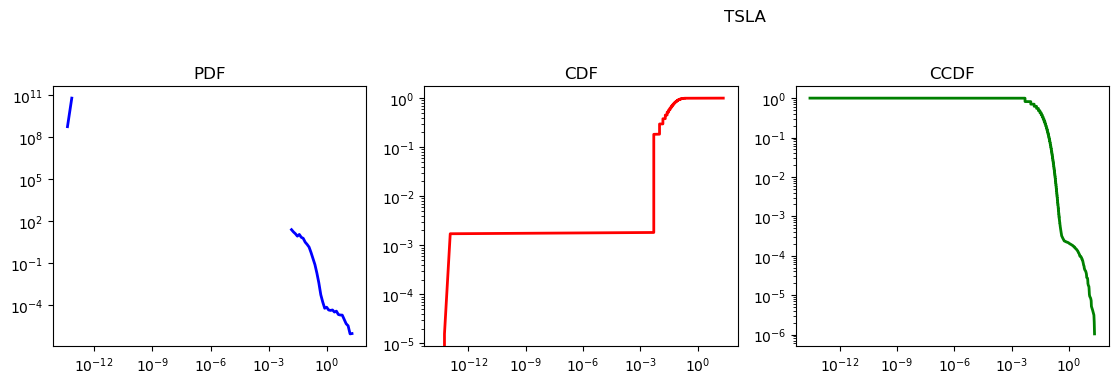

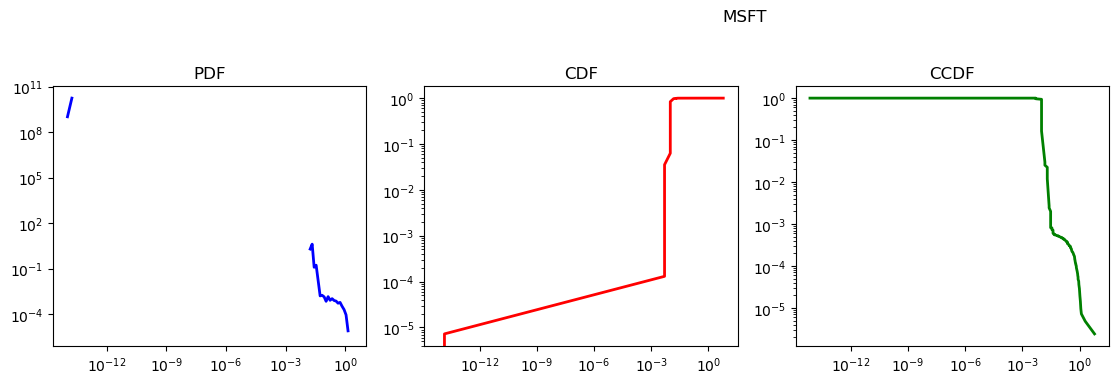

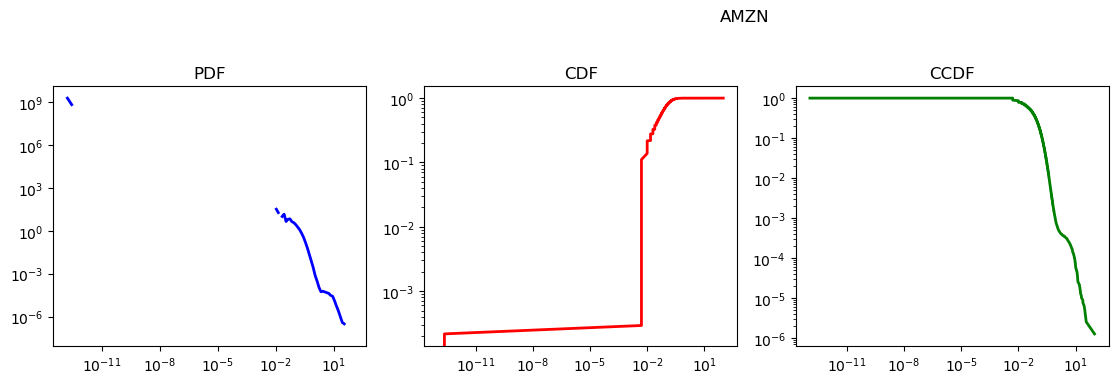

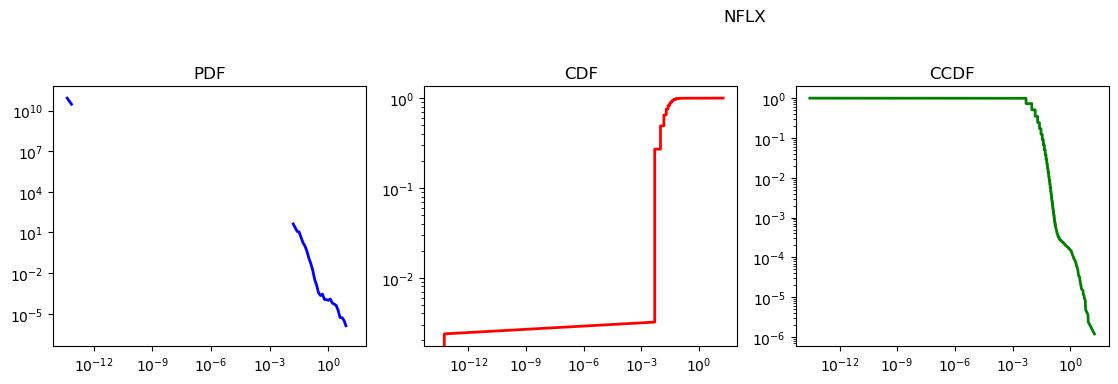

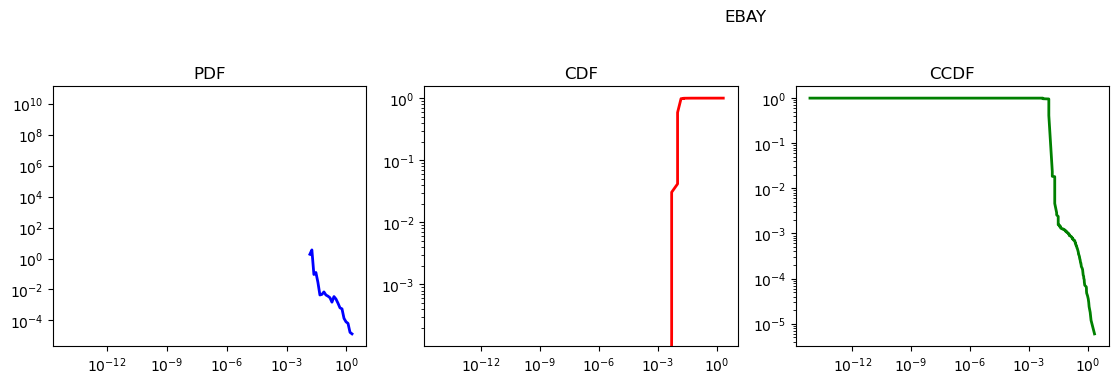

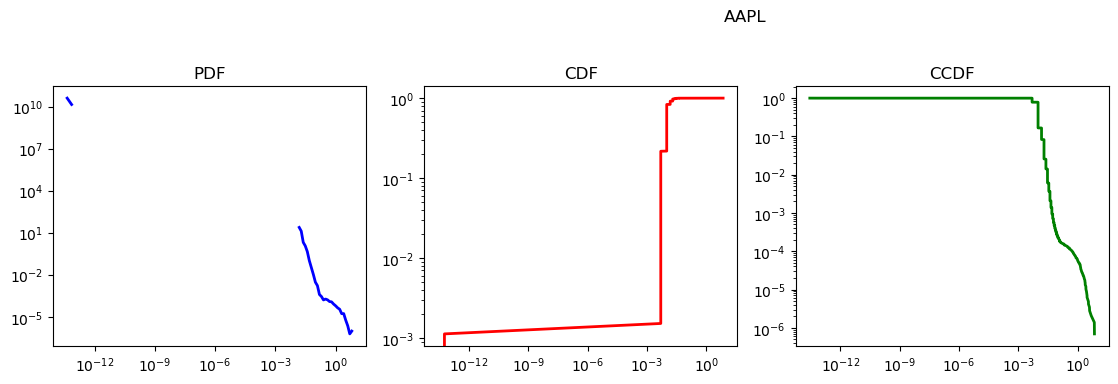

In [71]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### 4.3. Fit power law distribution to log returns

In [72]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volatility_distributions.pkl')

if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(data_dict=return_magnitudes, filename=volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x17764fd10>,
 'MSFT': <powerlaw.Fit at 0x173ee5d10>,
 'AMZN': <powerlaw.Fit at 0x173ee4450>,
 'NFLX': <powerlaw.Fit at 0x28f59d250>,
 'EBAY': <powerlaw.Fit at 0x2b6f53310>,
 'AAPL': <powerlaw.Fit at 0x2f11c0ad0>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

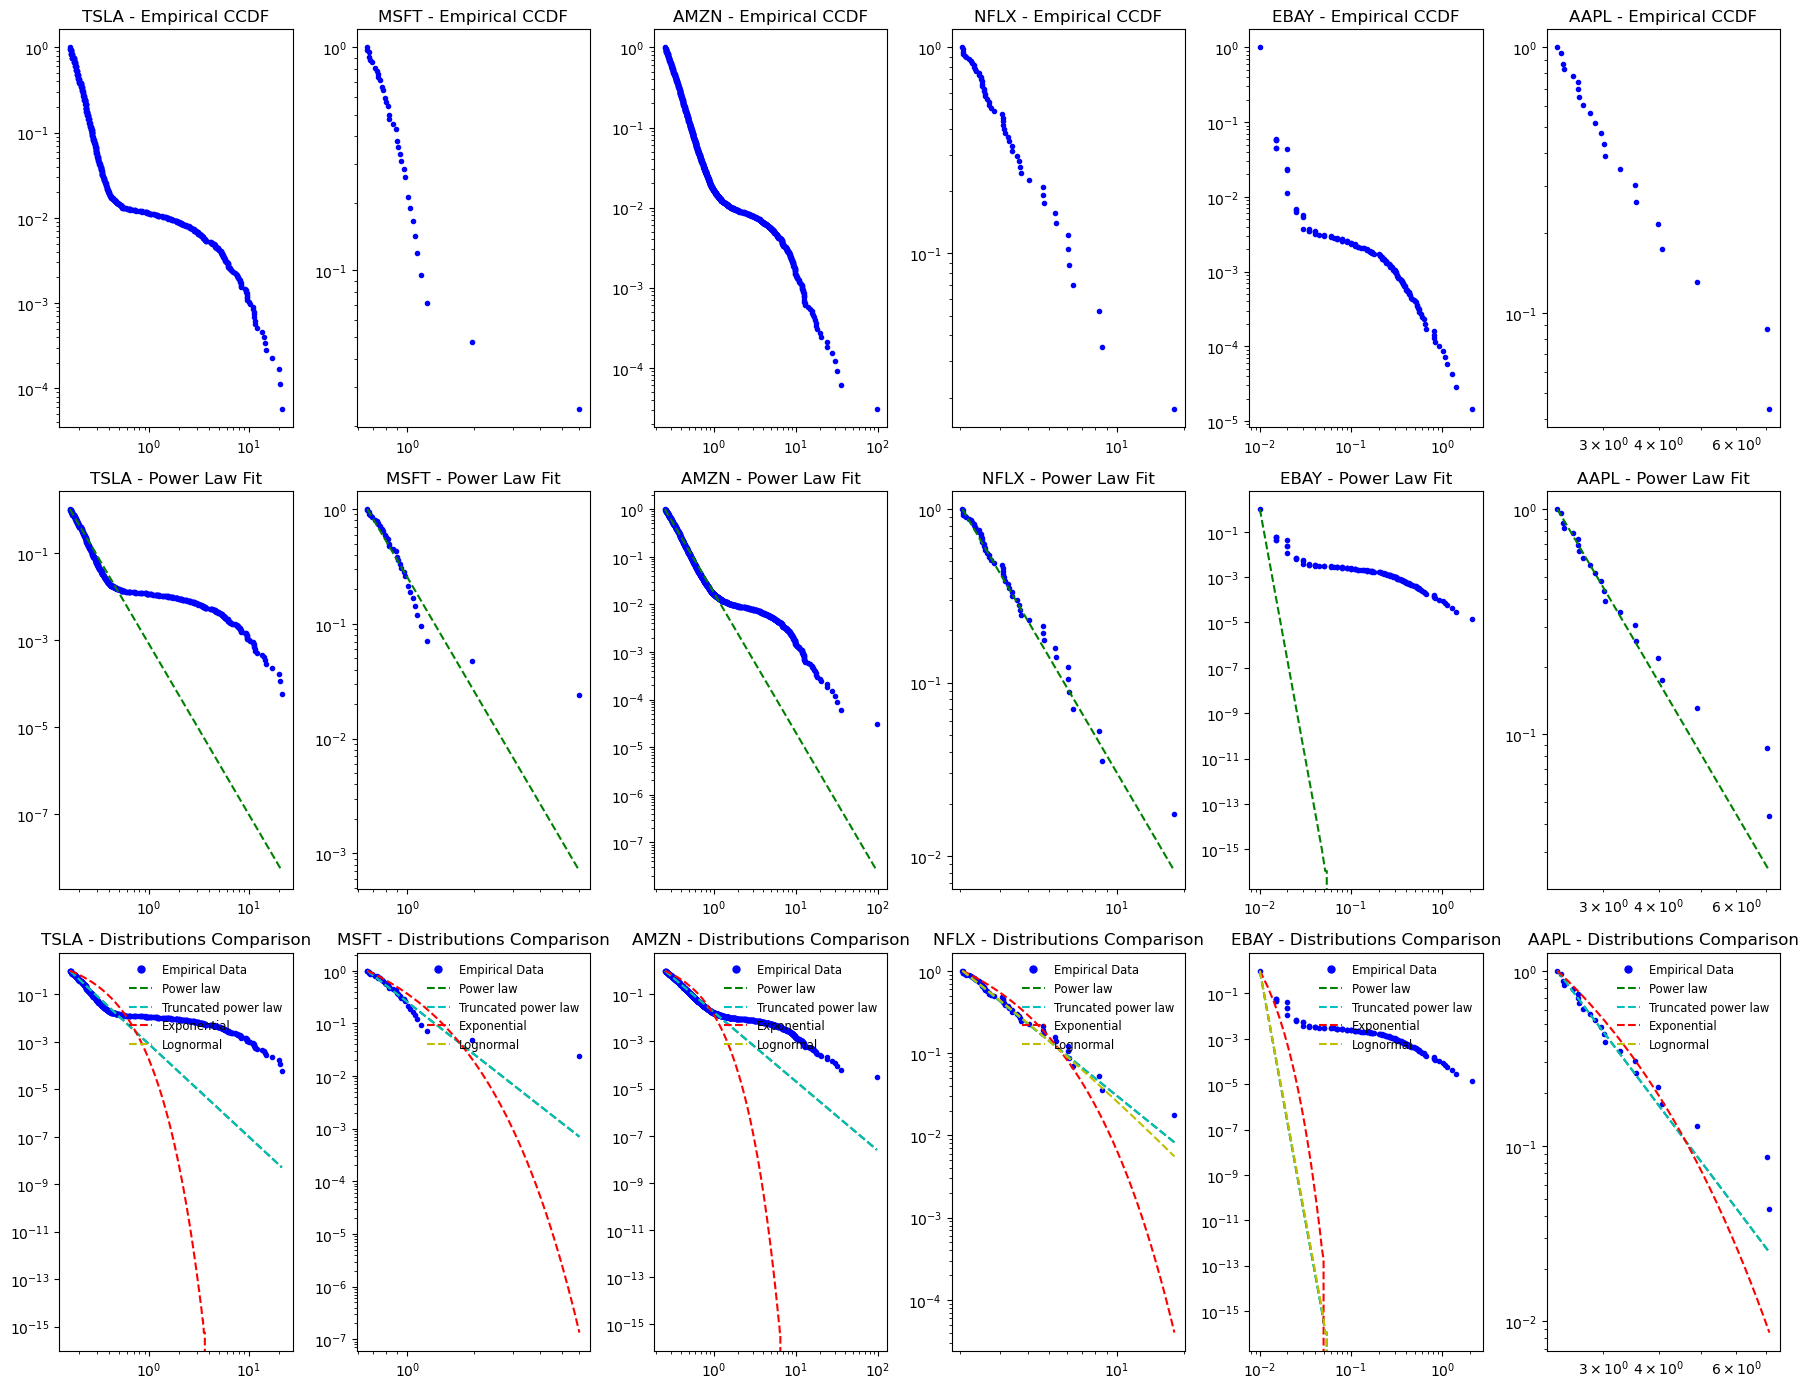

In [73]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 4.3.1. Retrieve Power law fitting results

In [74]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.896344  0.160     0.055694
1  MSFT    power_law   4.283514  0.660     0.075074
2  AMZN    power_law   3.938563  0.255     0.029374
3  NFLX    power_law   3.203476  2.045     0.065170
4  EBAY    power_law  23.073318  0.010     0.059137
5  AAPL    power_law   4.346849  2.360     0.062233


In [75]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.2034759132063497
Max Alpha: 23.07331816026005
Average Alpha: 7.290343982174072
std_dev_alpha: 7.752104571976945


In [76]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'truncated_power_law')
print(volatility_fit_results)

  Stock         Distribution      alpha        Lambda   xmin  KS Distance
0  TSLA  truncated_power_law   4.896453  8.125456e-09  0.160     0.055697
1  MSFT  truncated_power_law   4.283492  9.920563e-09  0.660     0.075073
2  AMZN  truncated_power_law   3.938560  7.239814e-08  0.255     0.029374
3  NFLX  truncated_power_law   2.944254  4.459020e-02  2.045     0.054535
4  EBAY  truncated_power_law  23.073271  1.176448e-08  0.010     0.059137
5  AAPL  truncated_power_law   4.311274  7.470438e-03  2.360     0.062548


In [77]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'exponential')
print(volatility_fit_results)

  Stock Distribution      Lambda   xmin  KS Distance
0  TSLA  exponential   10.310684  0.160     0.296100
1  MSFT  exponential    2.952597  0.660     0.145782
2  AMZN  exponential    5.711949  0.255     0.197352
3  NFLX  exponential    0.631486  2.045     0.138024
4  EBAY  exponential  743.173926  0.010     0.043362
5  AAPL  exponential    0.997412  2.360     0.126431


#### 3.3.2. Compare Alternative Distributions

In [78]:
# Compare against alternative heavy-tailed distributions
volatility_powerlaw_exponential = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,10.310684,0.160,4.896344,0.055694,0.296100,15.449563,7.595625e-54
1,MSFT,exponential,2.952597,0.660,4.283514,0.075074,0.145782,1.303548,1.923879e-01
2,AMZN,exponential,5.711949,0.255,3.938563,0.029374,0.197352,14.236648,5.426844e-46
3,NFLX,exponential,0.631486,2.045,3.203476,0.065170,0.138024,1.061620,2.884082e-01
4,EBAY,exponential,743.173926,0.010,23.073318,0.059137,0.043362,22.427329,2.130469e-111
5,AAPL,exponential,0.997412,2.360,4.346849,0.062233,0.126431,1.158871,2.465089e-01
